### one-hot 编码

one-hot 编码用来把一个类别标签转化为概率分布

如果是共有 5 个类别的话

例如标签 标签 tensor([1])

```python
转化为 tensor([
    [0, 1, 0, 0, 0]
])  # 第 1 号类别的概率为 1，其余为 0
```

In [1324]:
import torch
import torch.nn.functional as F

vec = torch.arange(3)
F.one_hot(vec, num_classes=5)  # 类别的个数为 5

tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [1325]:
mat = torch.tensor([
    [1, 2, 3],
    [4, 5, 6]
])

# batch_size, num_steps,  num_classes
mat1 = F.one_hot(mat, 7)
print(mat1.shape)

# num_steps, batch_size, num_classes
# 每次拿到所有样本的同一个时间步上的数据集
mat2 = F.one_hot(mat.T, 7)
print(mat2.shape)

torch.Size([2, 3, 7])
torch.Size([3, 2, 7])


In [1326]:
# one-hot 编码逆向转换

torch.argmax(torch.tensor([
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
]), dim=1)

tensor([2, 1, 3])

#### 创建虚拟数据序列

虚拟的数据集的词元是数值 0-19
长度为 1000

In [1327]:
from random import randint

seq = []

for i in range(100):
    # 每次生成长度为 10 的连续序列
    start = randint(0, 10)  # [0, 10] 闭区间随机一个数值
    for j in range(start, start+10):
        seq.append(j)

In [1328]:
len(seq), min(seq), max(seq)

(1000, 0, 19)

#### 构建数据集

In [1329]:
T = len(seq)  # 序列数据 seq 的长度
num_steps = 20  # 时间步长
num_classes = 20  # 有多少个种类的词元;用于生成 ont-hot 编码

In [1330]:
dtype = torch.int64

x = torch.tensor(seq, dtype=dtype)
X = torch.zeros((T-num_steps, num_steps), dtype=dtype)
Y = torch.zeros((T-num_steps, num_steps), dtype=dtype)

In [1331]:
for i in range(num_steps):
    X[:, i] = x[i:T-num_steps+i]
    Y[:, i] = x[i+1:T-num_steps+i+1]

In [1332]:
X[0, :11]

tensor([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  6])

In [1333]:
Y[0, :11]

tensor([ 7,  8,  9, 10, 11, 12, 13, 14, 15,  6,  7])

#### 创建数据迭代器

In [1334]:
batch_size = 50  # 批量大小

sample_epochs = X.shape[0] // batch_size
num_samples = sample_epochs * batch_size

from torch.utils import data
dataset = data.TensorDataset(X[:num_samples, :], Y[:num_samples, :])
diter =data.DataLoader(dataset=dataset, batch_size=batch_size)

In [1335]:
for _X, _Y in diter:
    print(_X.shape, ' and ', _Y.shape)

torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])
torch.Size([50, 20])  and  torch.Size([50, 20])


#### 浅尝 RNN 层的前向传播

In [1336]:
import torch
from torch import nn
import torch.nn.functional as F

In [1337]:
num_hiddens = 256  # rnn 隐藏层的输出个数 - 也是隐藏单元个数
num_classes = 20  # rnn 隐藏层的输入个数 - 也是 ont-hot 编码的长度 - 代表词元种类个数

In [1338]:
# 输入为 num_classes
# 输出为 num_hiddens
# 1 层 rnn 堆叠
rnn_layer = nn.RNN(num_classes, num_hiddens, 1)

#### 创建隐状态

每一个样本的前向传播过程都会产生一个隐状态，因此 $H$ 要有 batch_size 行，每一行都是前向传播过程中产生的一个隐状态, 而每个隐状态其实只是中间层的输出，所以有 num_hiddens 列

通过 rnn 层输出的是 new_H 也就是 new_state

In [1339]:
# size = (隐藏层个数，批量大小，神经元数量)
# 在下方的测试中仅含有 1 个数据样本
state = torch.zeros(size=(1, 1, num_hiddens))
state.shape

torch.Size([1, 1, 256])

In [1340]:
# (num_steps, batch_size, num_classes)

# 创建一个 x_t 样本用于测试 rnn_layer 层的前向传播
# 样本数量为 1 序列长度为 3
x_t = F.one_hot(torch.tensor([
    [1],
    [3],
    [4]
]), 20).float()
x_t.shape

torch.Size([3, 1, 20])

In [1341]:
# pred 是每一个输入的 词元 对应的输出值 形状与 x_t 相同
# new_state 是输出的新的隐状态，并且是最后一个时间步输入
# 后的最终的包含了所有输入过的序列信息的隐藏状态
pred, new_state = rnn_layer(x_t, state)
pred.shape, new_state.shape

(torch.Size([3, 1, 256]), torch.Size([1, 1, 256]))

In [1342]:
pred[2][0][:3]

tensor([-0.0046,  0.0575, -0.0757], grad_fn=<SliceBackward0>)

In [1343]:
new_state[0][0][:3]

tensor([-0.0046,  0.0575, -0.0757], grad_fn=<SliceBackward0>)

#### 矩阵的展开逻辑

从内层的维度向外层逐层展开

时间步数，批量大小，one-hot长度

第 0 步中的 第 0 号样本 的 one-hot 编码

第 0 步中的 第 1 号样本 的 one-hot 编码

...

以时间步作为分组排列在二维矩阵上

In [1344]:
# 时间步数，批量大小
data = torch.tensor([
    [1, 4],
    [2, 5],
    [3, 6]
])

data

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [1345]:
data = F.one_hot(data, 7)
data

tensor([[[0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1]]])

In [1346]:
data.reshape(-1, data.shape[-1])

tensor([[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]])

#### 构建 RNN 网络

In [1347]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # one-hot 编码长度 就是 20
        # 隐藏单元个数
        # 几层 rnn 堆叠
        self.rnn = nn.RNN(20, 256, 1)

        # 使用线性层将其转化为概率分布输出
        self.linear = nn.Linear(256, 20)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, inputs, state):
        # 先对输入的小批量样本矩阵做 ont-hot 编码
        X = F.one_hot(inputs.T.long(), 20)
        X = X.to(torch.float32)
        
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape(-1, Y.shape[-1]))
        output = self.softmax(output)
        return output, state

    def begin_state(self, batch_size):
        # rnn 网络堆叠层数，批量大小，隐藏单元个数
        return torch.zeros(size=(1, batch_size, 256))

tensor(2.1793, grad_fn=<MeanBackward0>)
tensor(2.1694, grad_fn=<MeanBackward0>)


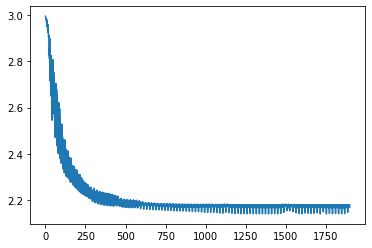

In [1348]:
net = RNNModel()
state = net.begin_state(50)

# 使用交叉熵损失函数
loss = nn.CrossEntropyLoss()

# 使用 SGD 作为优化器
updater = torch.optim.Adam(net.parameters(), lr=0.001)

all_loss = []
nums = 50

# 对所有的数据迭代 100 次
for i in range(100):
    for _X, _Y in diter:
        
        # 把 Y 进行转置后拉成一个向量
        # 这和 forward 函数产生的输出非常像
        # 如果再把 y 进行 one-hot 编码后
        # 就和 forward 函数中 output 的排布是一样的了
        y = _Y.T.reshape(-1)
        
        # 每开始议论新的小批量数据训练的时候让 state 置零
        # 因为当前这一批小批量数据和上一批数据是没关系的
        state = net.begin_state(batch_size=batch_size)
		
        # 产生预测 y_hat 和 新的 state
        y_hat, state = net(_X, state)
        
        # 这里的 loss 传入的 y_hat 是概率分布
        # loss 会自动对传入的 y.long() 进行 one-hot 编码
        # 然后对 y_hat 和 y.long() 计算交叉熵损失
        l = loss(y_hat, y.long()).mean()
        updater.zero_grad()
        l.backward()
        updater.step()
        all_loss.append(l)

    nums -= 1
    if nums <= 0:
        print(all_loss[-1])
        nums = 50

import matplotlib.pyplot as plt
import numpy as np

xs = np.arange(len(all_loss))
plt.plot(xs, all_loss)

In [1354]:
def predict(prefix, num_preds, net, device):  #@save
    """
    在prefix后面生成新字符
    num_preds: 后续要生成多少个值
    net: 你的模型
    device: 你要用 cpu 还是 gpu 计算
    """
    # batch_size = 1 ==> 对一个字符串做预测
    state = net.begin_state(batch_size=1)
    outputs = [int(prefix[0])]  # 把 prefix[0] 的数值类型放进 outputs 中
    
    # get_input 函数，每次从 outputs 末尾拿一个值
    # 然后构造成可以输入到 net 模型中的形状并返回
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    
    for y in prefix[1:]:  
        # 预热期 ==> 把 prefix 中的信息初始化到 state 中
        # y 是从 prefix 的 第1号 元素开始取值的
        # 当 y 取 prefix[1] 的时候，此时 get_input() 得到的输入是 prefix[0] 
        # 刚好是错开的，是没有问题的
        # 之所以 state 也是网络的输入参数
        # 就是要使用 state 保存 prefix 的信息
        # 这样就相当于让网络把 prefix 中的前缀信息都记住了
        # 然后后期再预测的时候就是基于 prefix 这一串前缀的基础上进行预测的
        # 而不是 prefix[-1] 这单个字符进行预测
        inputs = get_input()
        _, state = net(inputs, state)
        outputs.append(int(y))

    # 从这儿开始是预测 prefix 后边的字符
    # 每次都用上一次输出的值作为下一次输入的值
    # 上一次的输出值是一个时间步上的值，而不是一个序列
    # 但是并不用担心，之前所输入到网络中的新信息
    # 都被存储在了 state 中
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # index = int(y.argmax(dim=1))
        # outputs.append(y[0][index])
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    # 把 index 的值 转化成其 对应的 词（这里是字符）
    return outputs

In [1355]:
predict('66', 5, net, torch.device('cpu'))

[6, 6, 7, 8, 9, 10, 11]

In [1351]:
inputs = torch.tensor([
    [1, 5, 3, 1],
    [5, 3, 1, 1]
]).float()

softmax = nn.Softmax(dim=1)
softmax(inputs)

tensor([[0.0156, 0.8533, 0.1155, 0.0156],
        [0.8533, 0.1155, 0.0156, 0.0156]])